# Topic modeling example

This exercise introduces topic modeling using the LDA (Latent Dirichlet Allocation) algorithm and the Non-negative Matrix Factorisation (NMF) algorithm.

Topic modeling is an unsupervised approach that allows you to explore large text collections.

In this example, we use the gensim LDA and pyLDAvis implementations for one type of analysis, as well as the sklearn implementations of LDA and NMF to look at how the models relate to categories in the data. 

The main packages that are used in this example are:

nltk: http://www.nltk.org/ - for preprocessing

gensim: https://radimrehurek.com/gensim/ - for building the LDA model

pyLDAvis: https://github.com/bmabey/pyLDAvis - for visualization and easier exploration of the generated topics

sklearn: https://scikit-learn.org/stable/, https://scikit-learn.org/stable/modules/decomposition.html#nmf - for building LDA and NMF models

The example is inspired by, and uses functions from: http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/Gensim%20Newsgroup.ipynb
and
https://github.com/derekgreene/topic-model-tutorial/blob/master/2%20-%20NMF%20Topic%20Models.ipynb

Written by: Sumithra Velupillai, with input from Sonia Priou, February 2019 

In [2]:
## First we need to import all the necessary packages

import string
from gensim import models
from gensim.corpora import Dictionary, MmCorpus
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import itertools
import zipfile

try:
    import pyLDAvis
except ImportError as e:
    !pip install pyldavis
    import pyLDAvis

import pyLDAvis.gensim as gensimvis
import os
import pandas as pd

import re
import codecs
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

import numpy as np
from sklearn.decomposition import NMF, LatentDirichletAllocation
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings; warnings.simplefilter('ignore')



[nltk_data] Downloading package punkt to /Users/sumithra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sumithra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/sumithra/anaconda3/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


# 1: corpus
The first step in building a topic model is to read a corpus, or a collection of documents.

In this example, we are using documents from http://www.mtsamples.com/. 

These are transcribed medical transcriptions sample reports and examples from a variety of clinical disciplines, such as radiology, surgery, discharge summaries. Note that one document can belong to several categories. 

We will save each document, all its words, and which clinical specialty it belongs to, in a dataframe.


In [3]:
xlds = 'https://github.com/KCL-Health-NLP/nlp_examples/blob/master/topic_modelling/mtsamples_for_topic_modelling.xlsx?raw=true'
df = pd.read_excel(xlds)

How many documents are in the data?

In [4]:
len(df)

6385

How many clinical specialties are in the data? 

In [5]:
df['Category'].value_counts()

85-surgery                   1103
97-consult                    516
97-consult-historyandphy.     516
6-cardiovascularpulmonary     372
49-orthopedic                 355
95-radiology                  273
98-general                    259
98-generalmedicine            259
24-gastroenterology           230
42-neurology                  223
91-soapchartprogressnotes     166
45-obstetricsgynecology       160
82-urology                    158
89-dischargesummary           108
89-discharge                  108
100-ent                        98
100-ent-otolaryngology         98
43-neurosurgery                94
96-hematology                  90
96-hematology-oncology         90
46-ophthalmology               83
41-nephrology                  81
93-emergencyroomreports        75
93-emergency                   75
66-pediatrics                  70
66-pediatrics-neonatal         70
105-painmanagement             62
105-pain                       62
72-psychiatrypsychology        53
87-officenotes

We need to convert the texts to words - let's use a very simple approach

In [6]:
def getWords(row):
    
    return [''.join(c.lower() for c in s if c not in string.punctuation) for s in nltk.word_tokenize(row)]

df['Document words'] = df['Document Content'].apply(getWords)


# 2 Using gensim and pyLDAVis

We now need to generate representations for the vocabulary (dictionary) and the text collection (corpus)

Let's use some functions that we can call later, and that we can modify later if we want.

(Using all the words in the whole corpus or text collection is not typically what you want, because very common words, 

or very rare words will not generate good topic representations. Why?

What parameters and configurations could be interesting to change below?)

In [19]:

## functions from http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/Gensim%20Newsgroup.ipynb

## this function returns a set of stopwords predefined in the nltk package

def nltk_stopwords():
    return set(nltk.corpus.stopwords.words('english'))

## this function prepares the data and returns a dictionary and a corpus.
## which parameters do you think would be worth modifying/experimenting with?

def prep_corpus(docs, additional_stopwords=set(), no_below=5, no_above=0.5):
  print('Building dictionary...')
  dictionary = Dictionary(docs)
  stopwords = nltk_stopwords().union(additional_stopwords)
  stopword_ids = map(dictionary.token2id.get, stopwords)
  dictionary.filter_tokens(stopword_ids)
  dictionary.compactify()
  dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=None)
  dictionary.compactify()

  print('Building corpus...')
  corpus = [dictionary.doc2bow(doc) for doc in docs]

  return dictionary, corpus




In [20]:
## now, let's use the functions we defined above to get our dictionary and corpus
dictionary, corpus = prep_corpus(df['Document words'])

Building dictionary...
Building corpus...


In [21]:
## If you want, you can save your corpus and dictionary to disk for quicker processing later

#MmCorpus.serialize('/Users/sumithra/DSV/MeDESTO/teaching/Farr2017/data/gensim_topic_model_data/mtsamples.mm', corpus)
#dictionary.save('/Users/sumithra/DSV/MeDESTO/teaching/Farr2017/data/gensim_topic_model_data/mtsamples.dict')

In [22]:
## Now we have our dictionary and corpus, let's generate an LDA model.
## The LDA model has many parameters that can be set, all available parameters can be found here:
## https://radimrehurek.com/gensim/models/ldamodel.html

## Here, we've set the number of topics to 10.

lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, passes=10)

## You can also save the generated model to disk if you want
#lda.save('/Users/sumithra/DSV/MeDESTO/teaching/Farr2017/data/gensim_topic_model_data/mtsamples_20_lda.model')

In [23]:
## you can now look at these topics by printing them from the generated model

lda.print_topics()

[(0,
  '0.015*"placed" + 0.010*"incision" + 0.009*"procedure" + 0.009*"using" + 0.009*"skin" + 0.008*"used" + 0.007*"room" + 0.007*"removed" + 0.006*"operating" + 0.006*"taken"'),
 (1,
  '0.008*"mother" + 0.007*"also" + 0.006*"weight" + 0.004*"mom" + 0.004*"without" + 0.004*"blood" + 0.004*"one" + 0.004*"see" + 0.004*"sleep" + 0.004*"problems"'),
 (2,
  '0.012*"pain" + 0.007*"without" + 0.007*"denies" + 0.006*"clear" + 0.005*"chest" + 0.005*"blood" + 0.004*"bilaterally" + 0.004*"present" + 0.004*"negative" + 0.004*"regular"'),
 (3,
  '0.020*"mg" + 0.009*"dr" + 0.008*"po" + 0.007*"blood" + 0.007*"also" + 0.007*"day" + 0.005*"time" + 0.005*"hospital" + 0.004*"discharge" + 0.004*"daily"'),
 (4,
  '0.015*"negative" + 0.008*"without" + 0.007*"nasal" + 0.006*"noted" + 0.006*"exam" + 0.005*"ear" + 0.005*"evidence" + 0.005*"intact" + 0.005*"ct" + 0.005*"revealed"'),
 (5,
  '0.010*"placed" + 0.009*"bladder" + 0.008*"renal" + 0.007*"cm" + 0.007*"abdomen" + 0.006*"procedure" + 0.006*"removed" + 0

In [24]:

## It can be hard to get a good understanding of what's actually in these topics
## Visualizations are very helpful for this, let's use a package that does this:

vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

Take a look at the results. What observations do you have? What happens if you change the number of topics?

# 3 Using sklearn and comparing with 'existing' categories

Now you have seen how you can build a topic models with gensim and look at the contents visually with pyLDAVis.

You can also use sklearn for topic modeling, both lda and nmf, and analyse results visually by comparing with existing categories, if you have them.

NMF approaches can be very efficient, particularly with smaller datasets. Let's see what you think.



In [142]:
# We need a couple of functions to visualise the data
# Preparation for visualisation 
# Written by Sonia Priou, adaptations by Sumithra Velupillai

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

def get_topic_list(model, feature_names, no_top_words):
    tlist = {}
    for topic_idx, topic in enumerate(model.components_):
        tlist[topic_idx]= str("%d: " % (topic_idx)+", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
    return tlist

    
def display_topic_representation (model,dataframe,tlist):
    doc_topic = model    #example : model = lda_Tfidf.transform(tfidf)
    doc = np.arange(doc_topic.shape[0])
    num_topics = doc_topic.shape[1]
    dico = {'index': doc}
    for n in range(num_topics):
        dico["topic" + str(n)] = doc_topic[:,n]
    
    #Max topic 
    Topic_max = []
    for i in range(doc_topic.shape[0]):
        if len(set(doc_topic[i])) == 1:
            Topic_max.append(num_topics+1)
        else:
            Topic_max.append(doc_topic[i].argmax())
    dico["Topic most represented"] = Topic_max
    #print(Topic_max)
    tlist[num_topics+1] = 'NONE'
    dico["Topic and its most representative words"] = [tlist[x] for x in Topic_max]
    df_topic = pd.DataFrame(dico)

    
    #Link both DataFrame
    df_result = pd.merge(dataframe,df_topic, on='index')
    df_result = df_result.sort_values('Topic most represented')
    
    #Finding within the cluster found by LDA the original file
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    sns.set_style('whitegrid')
    sns.countplot(y='Topic and its most representative words', data = df_result)
    return df_result

def display_file_representation (model,dataframe):
    #Within a file, what is the slipt between topics found
    doc_topic = model    #example : model = lda_Tfidf.transform(tfidf)
    doc = np.arange(doc_topic.shape[0])
    no_topics = doc_topic.shape[1]
    topic = np.arange(no_topics)
    dico = {'index': doc}
    for n in range(no_topics):
        dico["topic" + str(n)] = doc_topic[:,n]
    #Max topic 
    Topic_max = []
    for i in range(doc_topic.shape[0]):
        Topic_max.append(doc_topic[i].argmax())
    dico["Topic most represented"] = Topic_max
    df_topic = pd.DataFrame(dico)
    #print(df_topic)
    
    
    #Link both DataFrame
    df_result = pd.merge(dataframe,df_topic, on='index')
    
    dico2 = {'Topic': topic}
    for i in df_result['Category'].value_counts().index:
        ser = df_result.loc[df_result['Category']==i].mean()
        score = ser[2:no_topics+2]
        dico2[i]=score

    df_score = pd.DataFrame(dico2)
    print('For each given file, we calculate the mean percentage of the documents depence to each topic')
    print('')
    print(df_score)
    print(df_result['Category'].value_counts().index)

    fig, axs = plt.subplots(ncols=len(dataframe['Category'].value_counts()))
    count = 0
    for i in df_result['Category'].value_counts().index:
        sns.barplot(x='Topic', y =i ,data = df_score, ax=axs[count])
        count = count + 1
        
    plt.tight_layout()

Let's look at a smaller sample, to make the analysis a bit easier. You can choose other categories of course!

In [117]:
categories_to_keep = ['17-dentistry', '46-ophthalmology', '72-psychiatrypsychology', '71-podiatry']
df_smaller = df.loc[df['Category'].isin(categories_to_keep)]
df_smaller['index'] = range(0,len (df_smaller))
df_smaller.head()

,Unnamed: 0,index,Category,Document Name,Document Content,Document words
475,475,0,17-dentistry,2336-bonyimpactedteethremoval.txt,PREOPERATIVE D...,"[preoperative, diagnosis, , completely, bony, ..."
476,476,1,17-dentistry,1260-dentalpain-emergencyvisit.txt,CHIEF COMPLAIN...,"[chief, complaint, , dental, painhistory, of, ..."
477,477,2,17-dentistry,2748-jawpain-ervisit.txt,CHIEF COMPLAIN...,"[chief, complaint, , jaw, painhistory, of, pre..."
478,478,3,17-dentistry,1916-odontogenicabscessid.txt,PREOPERATIVE D...,"[preoperative, diagnoses1, , left, facial, cel..."
479,479,4,17-dentistry,2338-teethextractionid.txt,PREOPERATIVE D...,"[preoperative, diagnoses1, , carious, teeth, ,..."


Now let's use sklearn's function for converting corpora to document-term-matrices

In [118]:
def get_tfidf_model(min_df = 5, max_df=100000, lowercase = True, dataframe, text_column):
    stopwords = nltk.corpus.stopwords.words('english')
    min_df = 5
    max_df = 100000
    lowercase = True
    

    bow_transformer = CountVectorizer(stop_words=stopwords, 
                                  min_df=min_df, 
                                  max_df=max_df, 
                                  lowercase = lowercase).fit(dataframe['Document Content'])
    document_bow = bow_transformer.transform(df_smaller['Document Content'])
feature_names = bow_transformer.get_feature_names()

tfidf_transformer = TfidfTransformer().fit(document_bow)
document_tfidf= tfidf_transformer.transform(document_bow)

How many features do you now have? What parameters can you change?

In [119]:
print(len(feature_names))

2238


Let's also make some functions to get the different topic models 

In [120]:
def getNMFModel(no_topics, document_tfidf):
    nmf = NMF(n_components=no_topics, 
          random_state=1, 
          alpha=.1, 
          l1_ratio=.5, 
          init='nndsvd').fit(document_tfidf)

    W = nmf.transform(document_tfidf)
    H = nmf.components_
    return nmf, W, H

def getLDAModel(no_topics, document_tfidf):
    lda = LatentDirichletAllocation(n_components=no_topics).fit(document_tfidf)
    return lda

How many topics do you want the model to generate?
How many discriminative words from each topic do you want to look at? 

In [121]:
no_topics = 4
no_top_words = 10

Now let's build an lda model

In [122]:
lda = getLDAModel(no_topics, document_tfidf)

Let's look at the most discriminative words for each topic. Do you see a pattern? Do you think more work needs to be done with the underlying representation?

In [123]:
display_topics(lda,feature_names, no_top_words)

Topic 0:
patient, history, foot, quot, left, mg, pain, tooth, normal, axis
Topic 1:
osseous, overlying, border, pattern, surrounding, interpretation, calcaneus, minor, abnormal, imaging
Topic 2:
osseous, overlying, border, pattern, surrounding, interpretation, calcaneus, minor, abnormal, imaging
Topic 3:
eye, procedure, right, placed, chamber, patient, anterior, used, lens, incision


We can now look at the main topic for each document. Does this look reasonable to you? 

Representation of the main topic for each document


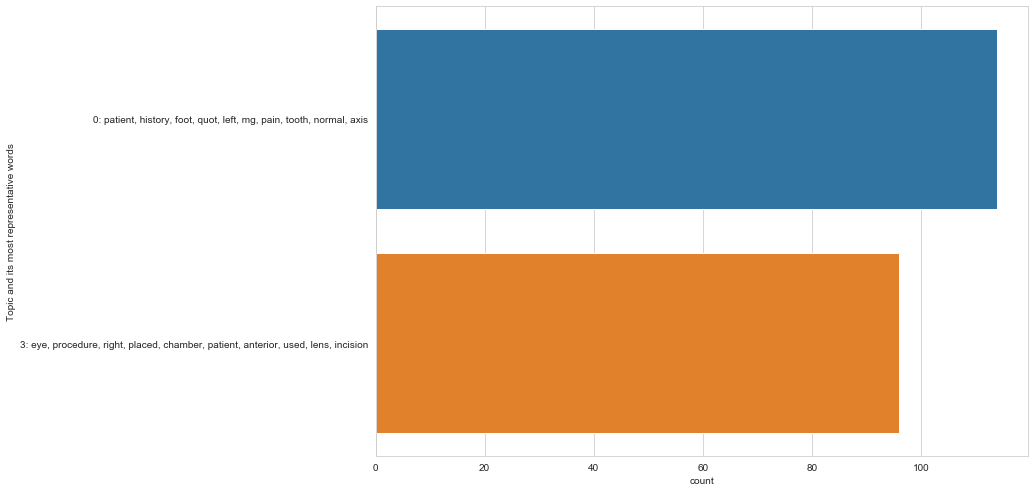

In [124]:
print('Representation of the main topic for each document')
tlist = get_topic_list(lda,feature_names, 10)
df_result = display_topic_representation(lda.transform(document_tfidf),df_smaller,tlist)

Now let's look at the distribution of topics in the files in relation to the 'existing' categories

For each given file, we calculate the mean percentage of the documents depence to each topic

        Topic  46-ophthalmology  72-psychiatrypsychology  71-podiatry  \
topic0      0          0.221083                 0.937129     0.575651   
topic1      1          0.026099                 0.020766     0.026895   
topic2      2          0.026099                 0.020766     0.026895   
topic3      3          0.726718                 0.021339     0.370560   

        17-dentistry  
topic0      0.537059  
topic1      0.024709  
topic2      0.024709  
topic3      0.413523  
Index(['46-ophthalmology', '72-psychiatrypsychology', '71-podiatry',
       '17-dentistry'],
      dtype='object')


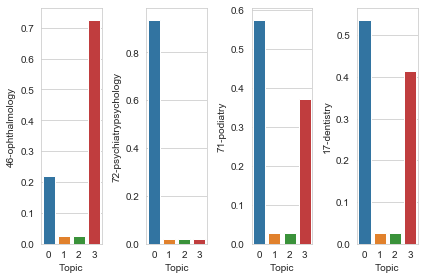

In [125]:
display_file_representation(lda.transform(document_tfidf),df_smaller)

Now let's compare with NMF.  

In [126]:
nmf, W, H = getNMFModel(no_topics, document_tfidf)

In [127]:
display_topics(nmf, feature_names, no_top_words)

Topic 0:
eye, chamber, lens, anterior, cataract, right, bag, used, placed, capsular
Topic 1:
patient, history, quot, mg, axis, mother, past, disorder, denies, family
Topic 2:
foot, left, patient, right, ankle, plantar, tendon, metatarsal, lateral, incision
Topic 3:
teeth, tooth, caries, dental, mandible, patient, buccal, ml, throat, left


Representation of the main topic for each document


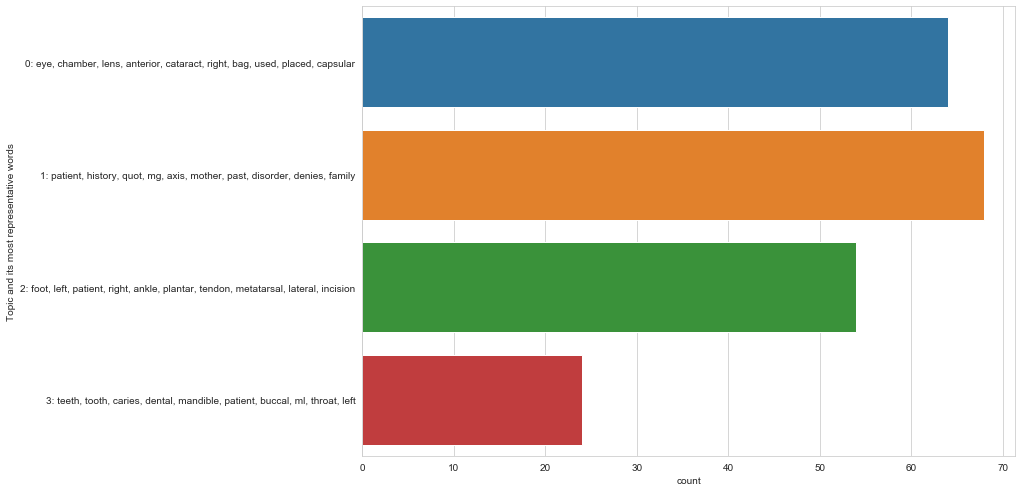

In [128]:
print('Representation of the main topic for each document')
#display_topic_representation(W,df_smaller)

tlist = get_topic_list(nmf,feature_names, 10)
df_result = display_topic_representation(W,df_smaller,tlist)


In [129]:
df_result

,Unnamed: 0,index,Category,Document Name,Document Content,Document words,topic0,topic1,topic2,topic3,Topic most represented,Topic and its most representative words
149,5406,149,46-ophthalmology,165-blepharonentropionrepair.txt,PREOPERATIVE D...,"[preoperative, diagnoses1, , entropion, , left...",0.127123,0.000000,0.077401,0.015189,0,"0: eye, chamber, lens, anterior, cataract, rig..."
85,5342,85,46-ophthalmology,1894-nasolacrimalprobing.txt,PREOPERATIVE D...,"[preoperative, diagnoses, , tearing, , eyelash...",0.111500,0.042075,0.092020,0.037452,0,"0: eye, chamber, lens, anterior, cataract, rig..."
84,5341,84,46-ophthalmology,1966-yaglasercapsulotomy-1.txt,PREOPERATIVE D...,"[preoperative, diagnosis, , secondary, capsula...",0.199940,0.024238,0.000000,0.000000,0,"0: eye, chamber, lens, anterior, cataract, rig..."
83,5340,83,46-ophthalmology,1896-yaglasercapsulotomy.txt,PREOPERATIVE D...,"[preoperative, diagnosis, , visually, signific...",0.190304,0.048154,0.014805,0.000000,0,"0: eye, chamber, lens, anterior, cataract, rig..."
82,5339,82,46-ophthalmology,2187-phacoemulsificationcataractextraction-4.txt,PREOPERATIVE D...,"[preoperative, diagnosis, , cataract, , right,...",0.413614,0.000000,0.000000,0.000000,0,"0: eye, chamber, lens, anterior, cataract, rig..."
...,...,...,...,...,...,...,...,...,...,...,...,...
23,498,23,17-dentistry,2756-dentalpain.txt,CHIEF COMPLAIN...,"[chief, complaint, , dental, painhistory, of, ...",0.000000,0.118311,0.029210,0.175154,3,"3: teeth, tooth, caries, dental, mandible, pat..."
24,499,24,17-dentistry,1279-fullmouthdentalrehabilitation-2.txt,OPERATION PERF...,"[operation, performed, , full, mouth, dental, ...",0.017973,0.052691,0.000000,0.467430,3,"3: teeth, tooth, caries, dental, mandible, pat..."
26,501,26,17-dentistry,2337-cariousteethextraction.txt,PREOPERATIVE D...,"[preoperative, diagnosis, , carious, teeth, an...",0.000000,0.000000,0.000000,0.519000,3,"3: teeth, tooth, caries, dental, mandible, pat..."
13,488,13,17-dentistry,1626-extraoralid.txt,PREOPERATIVE D...,"[preoperative, diagnosis, , left, masticator, ...",0.013451,0.000000,0.055113,0.438569,3,"3: teeth, tooth, caries, dental, mandible, pat..."


For each given file, we calculate the mean percentage of the documents depence to each topic

          Topic  46-ophthalmology  72-psychiatrypsychology  71-podiatry  \
topic0_x      0          0.217147                 0.000103     0.003959   
topic1_x      1          0.024771                 0.304825     0.033483   
topic2_x      2          0.025931                 0.000444     0.278998   
topic3_x      3          0.007534                 0.000000     0.003497   

          17-dentistry  
topic0_x      0.009361  
topic1_x      0.043000  
topic2_x      0.029675  
topic3_x      0.349090  
Index(['46-ophthalmology', '72-psychiatrypsychology', '71-podiatry',
       '17-dentistry'],
      dtype='object')


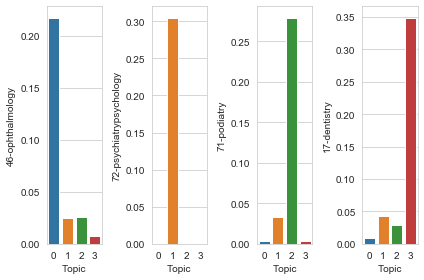

In [130]:
display_file_representation(W,df_result)

In [131]:
stopwords = nltk.corpus.stopwords.words('english')
min_df = 5
max_df = 100000
lowercase = True
ngram_range = 2

bow_transformer = CountVectorizer(stop_words=stopwords, 
                                  min_df=min_df, 
                                  max_df=max_df, 
                                  lowercase = lowercase).fit(df['Document Content'])
document_bow = bow_transformer.transform(df['Document Content'])
feature_names = bow_transformer.get_feature_names()

tfidf_transformer = TfidfTransformer().fit(document_bow)
document_tfidf= tfidf_transformer.transform(document_bow)

In [270]:
no_topics = 10
no_top_words = 10

In [271]:
nmf, W, H = getNMFModel(no_topics, document_tfidf)

In [303]:
lda = getLDAModel(no_topics, document_tfidf)

Representation of the main topic for each document


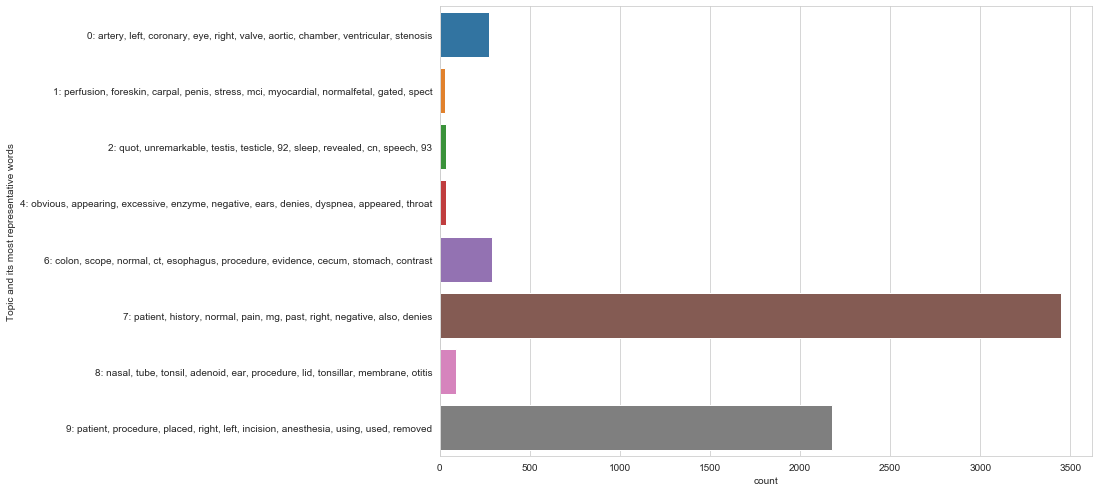

In [306]:
print('Representation of the main topic for each document')
#display_topic_representation(W,df_smaller)

tlist = get_topic_list(lda,feature_names, 10)
df_result = display_topic_representation(lda.transform(document_tfidf),df,tlist)

In [307]:
def display_file_representation2 (dataframe):
    fig, axs = plt.subplots(ncols=len(dataframe['Category'].value_counts()), figsize=((len(dataframe['Category'].value_counts())+10),10))
    #fig, axs = plt.subplots(ncols=4)
    #len(grouped_single['Category'].value_counts())
    count = 0
    for i in dataframe['Category'].value_counts().index:
    #    #print(i)
        ser = dataframe.loc[dataframe['Category']==i]
    #    print(ser)
        sns.barplot(data = ser, ax=axs[count])
        axs[count].set_ylabel(i)
        
        for tick in axs[count].get_xticklabels():
            tick.set_rotation(45) 
        count = count + 1
    plt.tight_layout()

What main differences do you notice when comparing NMF and LDA results? Do you think one is better than the other? What parameters might be worth changing?

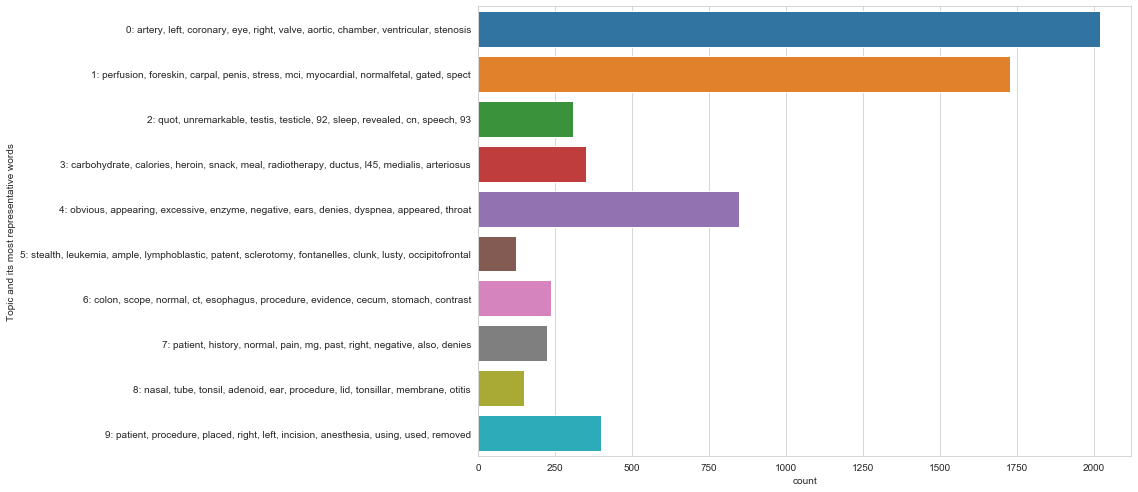

In [308]:
df_result = display_topic_representation(W,df,tlist)

pandas.core.frame.DataFrame

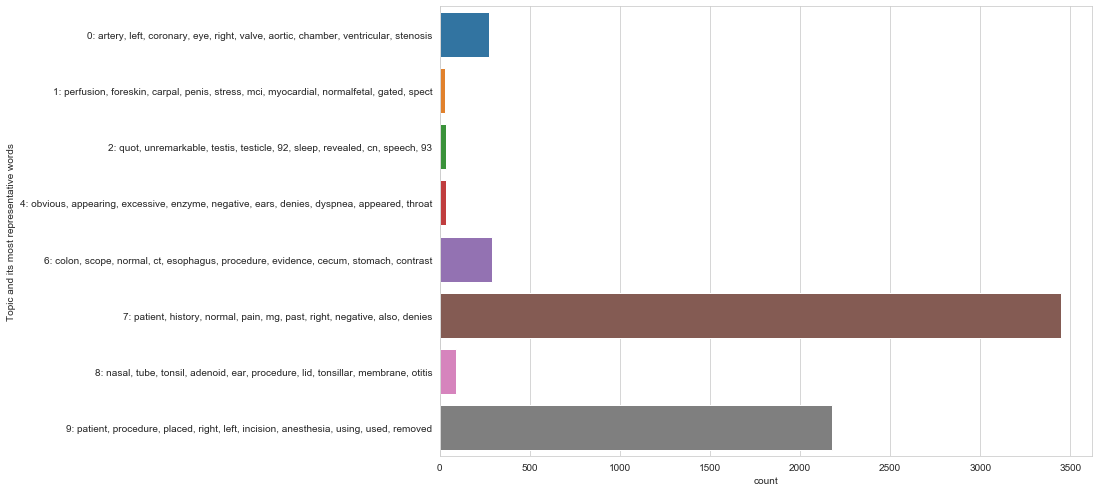

In [309]:
df_result = display_topic_representation(lda.transform(document_tfidf),df,tlist)

grouped_single = df_result.groupby('Category').agg({'topic0': ['mean'], 'topic1': ['mean'], 'topic2': ['mean'], 'topic3': ['mean'], 'topic4': ['mean'], 'topic5': ['mean'], 'topic6': ['mean'], 'topic7': ['mean'], 'topic8': ['mean'], 'topic9': ['mean']}).reset_index()
type(grouped_single)

In [310]:
#grouped_single = grouped_single.reset_index()
grouped_single.columns = ['Category', 'topic0', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7', 'topic8', 'topic9']

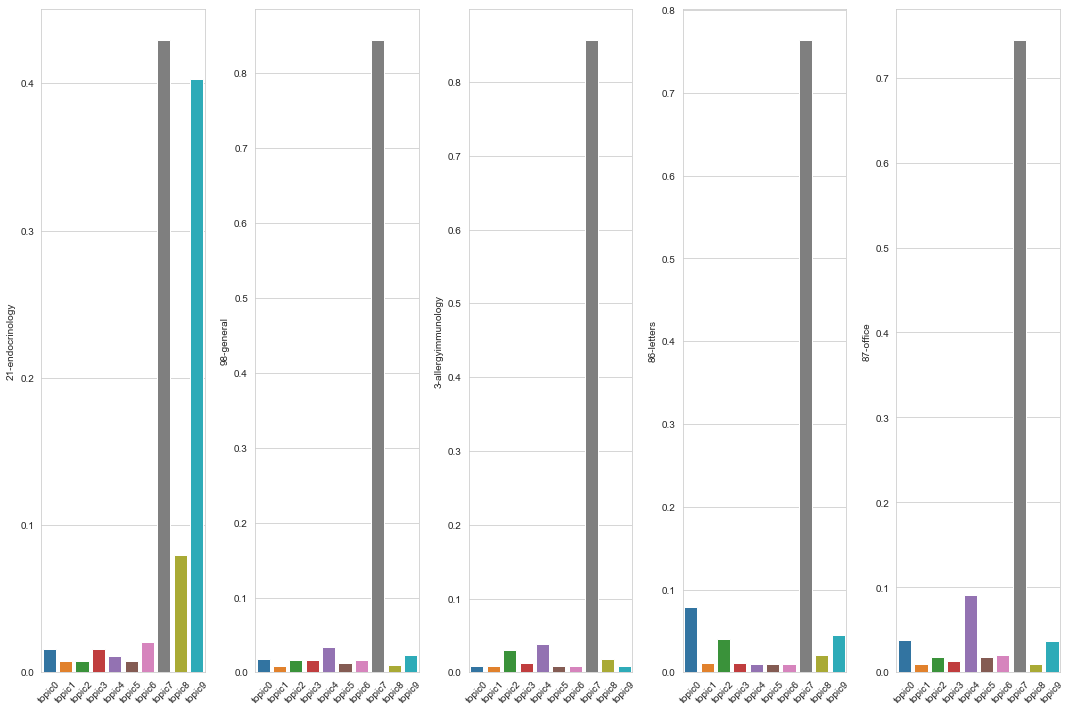

In [311]:
grouped_single = grouped_single.sample(5)
display_file_representation2(grouped_single)

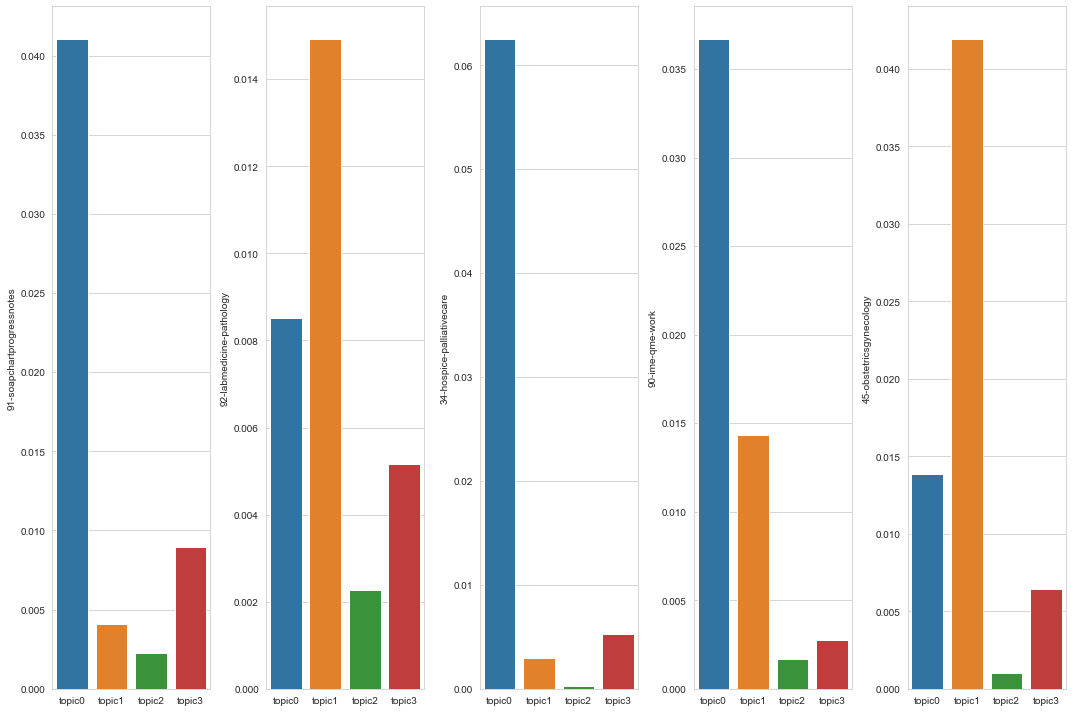

In [263]:
#grouped_single = grouped_single.sample(5)
#grouped_single.columns = grouped_single.columns.to_flat_index()
#grouped_single.columns
fig, axs = plt.subplots(ncols=len(grouped_single['Category'].value_counts()), figsize=((len(grouped_single['Category'].value_counts())+10),10))
#fig, axs = plt.subplots(ncols=4)
#len(grouped_single['Category'].value_counts())
count = 0
for i in grouped_single['Category'].value_counts().index:
#    #print(i)
    ser = grouped_single.loc[grouped_single['Category']==i]
#    print(ser)
    sns.barplot(data = ser, ax=axs[count])
    axs[count].set_ylabel(i)
    count = count + 1
#        
plt.tight_layout()

In [ ]:
# 2 Clustering with K means

# from: https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

stopwords = nltk.corpus.stopwords.words('english')
min_df = 1
max_df = 1.0
lowercase = True
ngram_range = 1
bow_transformer = TfidfVectorizer(stop_words=stopwords,  
                                  min_df=min_df, 
                                  max_df=max_df,
                                  ngram_range=(1,ngram_range),
                                  lowercase = lowercase).fit(df['Document Content'])

document_bow = bow_transformer.transform(df['Document Content'])
feature_names = bow_transformer.get_feature_names()

tfidf_transformer = TfidfTransformer().fit(document_bow)
document_tfidf= tfidf_transformer.transform(document_bow)

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        #sse.append(MiniBatchKMeans(n_clusters=k).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(document_tfidf, 50)

clusters = MiniBatchKMeans(n_clusters=20, init_size=1024, batch_size=2048, random_state=20).fit_predict(document_tfidf)

def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(', '.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(document_tfidf, clusters, bow_transformer.get_feature_names(), 10)